In [55]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [56]:
names = open('data/names.txt', 'r').read().splitlines()
names[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [57]:
letters = sorted(list(set(''.join(names))))
SoS = '<.>'
letters = [SoS] + letters 
letter2index = {l:i for i, l in enumerate(letters)}
index2letter = {i:l for l, i in letter2index.items()}
vocab_size = len(letter2index)
print(index2letter)

{0: '<.>', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [58]:
# build the dataset
def build_dataset(words, block_size):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in list(w) + [SoS]:
      ix = letter2index[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

block_size = 3 # context length: how many characters do we take to predict the next one?

Xtr,  Ytr  = build_dataset(names[:n1], block_size)     # 80%
Xdev, Ydev = build_dataset(names[n1:n2], block_size)   # 10%
Xte,  Yte  = build_dataset(names[n2:], block_size)     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [59]:
from typing import Any


class Embedding:

    def __init__(self, in_classes, emb_size) -> None:
        self.C = torch.randn((in_classes, emb_size))

    def __call__(self, x):
        self.output = self.C[x]
        return self.output
    
    def parameters(self):
        return [self.C]

class Flatten:

    def __init__(self, n=-1) -> None:
        self.n = n

    def __call__(self, x):
        if self.n < 0 or x.dim() <= 2:
            self.output = x.view(x.shape[0], -1)
            return self.output
        B, T, C = x.shape
        x = x.view(B, T//self.n, self.n * C)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.output = x
        return self.output
    
    def parameters(self):
        return []

class Linear:

    def __init__(self, in_features, out_features, bias=True) -> None:
        self.weight = torch.randn((in_features, out_features)) / (in_features**0.5)
        self.bias = torch.zeros(out_features) if bias else None

    def __call__(self, x):
        self.output = x @ self.weight
        if self.bias is not None:
            self.output += self.bias
        return self.output
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True, unbiased=True)
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.output = self.gamma * xhat + self.beta
        return self.output
    
    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:

    def __call__(self, x):
        self.output = F.tanh(x)
        return self.output
    
    def parameters(self):
        return []
    

class Sequential:

    def __init__(self, layers) -> None:
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.output = x
        return self.output
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [60]:


def random_batch(X, Y, batch_size):
    batch_idx = torch.randint(0, X.size(0), (batch_size, ))
    return X[batch_idx], Y[batch_idx]

def train(model, X_train, Y_train, n_steps, batch_size, print_every=10000):
    losses = []
    ud = []
    parameters = model.parameters()

    for p in parameters:
        p.requires_grad = True

    for i in range(n_steps):
        X_batch, Y_batch = random_batch(X_train, Y_train, batch_size)
        output = model(X_batch)
        loss = F.cross_entropy(output, Y_batch)

        for p in parameters:
            p.grad = None
        
        loss.backward()

        lr = 0.1 if i < 150000 else 0.01
        for p in parameters:
            p.data -= lr * p.grad

        losses.append(loss.item())
    
        if i % print_every == 0:
            print(f"{i:7d}/{n_steps:7d}: {loss.item():4f}")

    return model, losses, ud


In [61]:
embedding_size = 10
hidden_size = 200

torch.manual_seed(42)

model = Sequential(layers=[
    Embedding(vocab_size, embedding_size),
    Flatten(block_size),
    Linear(embedding_size * block_size, hidden_size, bias=False), BatchNorm1d(hidden_size), Tanh(),
    Linear(hidden_size, vocab_size)
])

model, losses, _ = train(model, Xtr, Ytr, 100000, batch_size=32)

      0/ 100000: 3.491530
  10000/ 100000: 2.217909
  20000/ 100000: 2.368145
  30000/ 100000: 2.134164
  40000/ 100000: 2.406682
  50000/ 100000: 2.240572
  60000/ 100000: 1.960829
  70000/ 100000: 1.923592
  80000/ 100000: 2.658750
  90000/ 100000: 2.050236


In [62]:
datasets = {
    "train": (Xtr, Ytr),
    "val": (Xdev, Ydev),
    "test": (Xte, Yte)
}

In [95]:
@torch.no_grad()
def split_loss(model, datasets, data_name):
    for layer in model.layers:
        layer.training = False
    x, y = datasets[data_name]
    pred = model(x)
    loss = F.cross_entropy(pred, y)
    print(data_name, loss.item())

In [64]:
split_loss(model, datasets, data_name='train')
split_loss(model, datasets, data_name='val')

train 2.143400192260742
val 2.1826789379119873


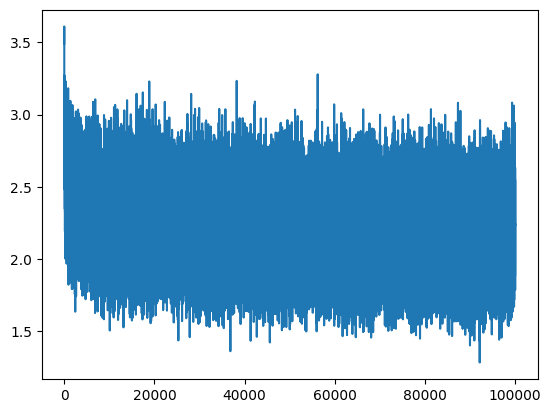

In [65]:
plt.plot(losses)

# Wavenet

![Wave Net](wavenet.png)

In [66]:
random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

block_size = 8 # context length: how many characters do we take to predict the next one?

Xtr,  Ytr  = build_dataset(names[:n1], block_size)     # 80%
Xdev, Ydev = build_dataset(names[n1:n2], block_size)   # 10%
Xte,  Yte  = build_dataset(names[n2:], block_size)     # 10%

torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


In [67]:
embedding_size = 10
hidden_size = 200

torch.manual_seed(42)

model = Sequential(layers=[
    Embedding(vocab_size, embedding_size),
    Flatten(block_size),
    Linear(embedding_size * block_size, hidden_size, bias=False), BatchNorm1d(hidden_size), Tanh(),
    Linear(hidden_size, vocab_size)
])

In [68]:
Xb, Yb = random_batch(Xtr, Ytr, batch_size=4)
logits = model(Xb)

In [69]:
Xb

tensor([[ 0,  0,  0, 11,  1, 13, 18, 25],
        [ 0,  0,  0,  0,  0, 25,  1, 14],
        [ 0,  0,  0,  0,  0,  0,  0, 20],
        [ 0,  0,  0,  0,  2,  5,  3, 11]])

In [70]:
model.layers[0].output.shape

torch.Size([4, 8, 10])

In [71]:
model.layers[1].output.shape

torch.Size([4, 80])

In [72]:
model.layers[2].output.shape

torch.Size([4, 200])

In [73]:
# (batch_size, 8 * embedding_size)
print((torch.randn((4, 80)) @ torch.randn((80, 200))).shape)
# (1, 2), (3, 4), (5, 6), (7, 8)
print((torch.randn((4, 80)).view(4, -1, 20) @ torch.randn((20, 200))).shape)


torch.Size([4, 200])
torch.Size([4, 4, 200])


In [42]:
torch.zeros((2, 2)).dim()

2

In [77]:
embedding_size = 10
hidden_size = 68

torch.manual_seed(42)

model = Sequential(layers=[
    Embedding(vocab_size, embedding_size), # 8
    Flatten(2), Linear(embedding_size * 2, hidden_size, bias=False), BatchNorm1d(hidden_size), Tanh(), # 4
    Flatten(2), Linear(hidden_size * 2, hidden_size, bias=False), BatchNorm1d(hidden_size), Tanh(), # 2
    Flatten(2), Linear(hidden_size * 2, hidden_size, bias=False), BatchNorm1d(hidden_size), Tanh(), # 1
    Linear(hidden_size, vocab_size)
])

In [78]:
logits = model(Xb)

In [79]:
for layer in model.layers:
    print(layer.__class__.__name__, layer.output.shape)

Embedding torch.Size([4, 8, 10])
Flatten torch.Size([4, 4, 20])
Linear torch.Size([4, 4, 68])
BatchNorm1d torch.Size([4, 4, 68])
Tanh torch.Size([4, 4, 68])
Flatten torch.Size([4, 2, 136])
Linear torch.Size([4, 2, 68])
BatchNorm1d torch.Size([4, 2, 68])
Tanh torch.Size([4, 2, 68])
Flatten torch.Size([4, 136])
Linear torch.Size([4, 68])
BatchNorm1d torch.Size([4, 68])
Tanh torch.Size([4, 68])
Linear torch.Size([4, 27])


In [80]:
model, losses, _ = train(model, Xtr, Ytr, 100000, batch_size=32)

      0/ 100000: 3.653908
  10000/ 100000: 2.222533
  20000/ 100000: 2.209970
  30000/ 100000: 1.683415
  40000/ 100000: 1.949772
  50000/ 100000: 2.052855
  60000/ 100000: 1.833406
  70000/ 100000: 2.441178
  80000/ 100000: 2.436555
  90000/ 100000: 2.374535


In [82]:
datasets = {
    "train": (Xtr, Ytr),
    "val": (Xdev, Ydev),
    "test": (Xte, Yte)
}

split_loss(model, datasets, data_name='train')
split_loss(model, datasets, data_name='val')

train 2.010878086090088
val 2.0767173767089844


# Fix the Batch Norm for multiple channels

In [89]:
e = torch.randn((32, 4, 68))
emean = e.mean(dim=0, keepdim=True)
evar = e.var(dim=0, keepdim=True)
evar.shape, emean.shape

(torch.Size([1, 4, 68]), torch.Size([1, 4, 68]))

In [90]:
e.mean(dim=tuple(range(e.dim() - 1)), keepdim=True).shape

torch.Size([1, 1, 68])

In [91]:
e = torch.randn((32, 100))
e.mean(dim=tuple(range(e.dim() - 1)), keepdim=True).shape

torch.Size([1, 100])

In [92]:
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            squeeze_dims = tuple(range(x.dim() - 1))
            xmean = x.mean(dim=squeeze_dims, keepdim=True).squeeze(squeeze_dims)
            xvar = x.var(dim=squeeze_dims, keepdim=True, unbiased=True).squeeze(squeeze_dims)
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.output = self.gamma * xhat + self.beta
        return self.output
    
    def parameters(self):
        return [self.gamma, self.beta]


In [93]:
embedding_size = 10
hidden_size = 68

torch.manual_seed(42)

model = Sequential(layers=[
    Embedding(vocab_size, embedding_size), # 8
    Flatten(2), Linear(embedding_size * 2, hidden_size, bias=False), BatchNorm1d(hidden_size), Tanh(), # 4
    Flatten(2), Linear(hidden_size * 2, hidden_size, bias=False), BatchNorm1d(hidden_size), Tanh(), # 2
    Flatten(2), Linear(hidden_size * 2, hidden_size, bias=False), BatchNorm1d(hidden_size), Tanh(), # 1
    Linear(hidden_size, vocab_size)
])

In [94]:
model, losses, _ = train(model, Xtr, Ytr, 100000, batch_size=32)

      0/ 100000: 3.631887
  10000/ 100000: 2.217933
  20000/ 100000: 2.219506
  30000/ 100000: 1.725441
  40000/ 100000: 1.895136
  50000/ 100000: 2.100642
  60000/ 100000: 1.718768
  70000/ 100000: 2.398021
  80000/ 100000: 2.477944
  90000/ 100000: 2.565272


In [96]:
split_loss(model, datasets, data_name='train')
split_loss(model, datasets, data_name='val')

train 1.9880826473236084
val 2.067246913909912
